# Tracing career histories of film directors from IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to our journey through the world of film, where we aim to unravel the mysteries behind the careers of movie directors! This notebook details the first steps towards understanding if and how connections with network brokers might enable women movie directors to enjoy longer and more impactful careers, and how these effects compare with their men counterparts. At this stage, our goal is to construct  a unique dataset of first-time movie directors and collecting data on their career trajectories using IMDb's data. For this task, we'll use pandas and matplotlib for data manipulation and visualization.

This notebook is divided into three parts:

1. Building a movie database

We begin by creating a comprehensive dataset of movies released from 2000 to 2023. This dataset will be the backbone for constructing dynamic collaboration networks of filmmakers, with each snapshot of the network capturing their collaboration ties within every three-year period.

2. Identifying first-time directors

Next, we zoom in on directors who made their debut from 2003 to 2013. We'll compile their filmographies up to 2023. This way, we ensure that we have at least a decade's view into each director's journey.

3. Examining directors' career before and after their debut

Lastly, we delve deeper into the pre- and post-debut career paths of these directors. Specifically, we count the number of movies they went on to direct after their debut. We'll also examine their industry involvement before becoming directors. This gives us a sense of how prior experiences in different filmmaking roles may shape their directorial paths.

These analyses lays the ground work for the second phase: calculating the levels of brokerage social capital of our directors and their collaborators over time.

# Acquiring movie data from 2000 to 2023 

In this section of the notebook, we gather data on movies released between 2000 and 2023. This data will later be used to construct an evolving collaboration network of film-makers, where each snapshot of the network encapsulates all collaboration ties over a span of three years.

We begin by importing essential Python libraries for data handling and visualization. The IMDb datasets, `title.basics` and `title.principals`, are then accessed directly from their URLs. These datasets contain comprehensive information about movies and their key personnel.

In [1]:
# Importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import os 

# set wd
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [8]:
# URLs of the IMDb data files
url_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Reading the TSV file directly from the URL in 28 Jan 2024
# 'sep' is set to '\t' for tab-separated values
# 'compression' parameter handles the gzip compression
# 'encoding' is set to 'utf-8' for proper character encoding
# 'low_memory=False' allows pandas to process large files without chunking
df_basics = pd.read_csv(url_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

With the `title.basics` dataset loaded, let's take a look at its first few rows to get an overview of its structure. We can also do a basic count to understand the distribution of different types of productions. 

In [40]:
# Displaying the first few rows of the 'df_basics' DataFrame to get an overview of the data structure
df_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,\N,1,"Comedy,Short"


In [41]:
# Counting the values in 'titleType' and 'isAdult' columns to understand their distribution in the dataset
{col: df_basics[col].value_counts() for col in ['titleType', 'isAdult']}

{'titleType': titleType
 tvEpisode       8042282
 short            974875
 movie            669892
 video            287189
 tvSeries         256237
 tvMovie          144193
 tvMiniSeries      52188
 tvSpecial         45647
 videoGame         37276
 tvShort           10240
 tvPilot               1
 Name: count, dtype: int64,
 'isAdult': isAdult
 0       10185807
 1         334195
 2023           6
 2019           3
 2020           2
 1981           1
 2017           1
 \N             1
 2022           1
 2011           1
 2014           1
 2005           1
 Name: count, dtype: int64}

The data includes both movies and tv shows (indicated in `titleType`) and indicates for whether these are pornographic productions (`isAdult`). Now, let's identify movies released between 2000 and 2023 and take a look at how many movies we have in the data. 

In [9]:
# Convert 'startYear' column to numeric, errors='coerce' sets unparsable entries as NaN (Not a Number)
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')

# Filtering the 'df_basics' DataFrame to include only non-adult movies with a valid start year
# 'query' function is used to filter rows where titleType is 'movie', isAdult is '0' (non-adult),
# and startYear is not NaN (ensured by 'startYear == startYear')
# 'filter' function selects revelant columns only
movies = (df_basics
          .query('titleType == "movie" & isAdult == "0" & startYear == startYear') 
          .filter(items=['tconst', 'startYear', 'genres'])  
          )

# Displaying the number of unique values in each column of the 'movies' DataFrame
movies.nunique()

tconst       563624
startYear       135
genres         1338
dtype: int64

As of the time of this analysis (Jan 29, 2024), the data includes 563,624 non-pornographic movies spaning 135 years. What are the earlies and latest year we have in the data?

In [10]:
# Finding and printing the earliest and latest years in the 'movies' DataFrame
print("Earliest Year:", movies['startYear'].min())
print("Latest Year:", movies['startYear'].max())

Earliest Year: 1894.0
Latest Year: 2031.0


The earliest year we have data on is 1894 and the latest year 2031. Seems like IMDb also has info on movies that have not been released yet. Let’s remove these future movies and graph the number of movies in the database over time.

In [ ]:
# Filter out movies released after 2023
movies = movies[movies['startYear'] <= 2023]

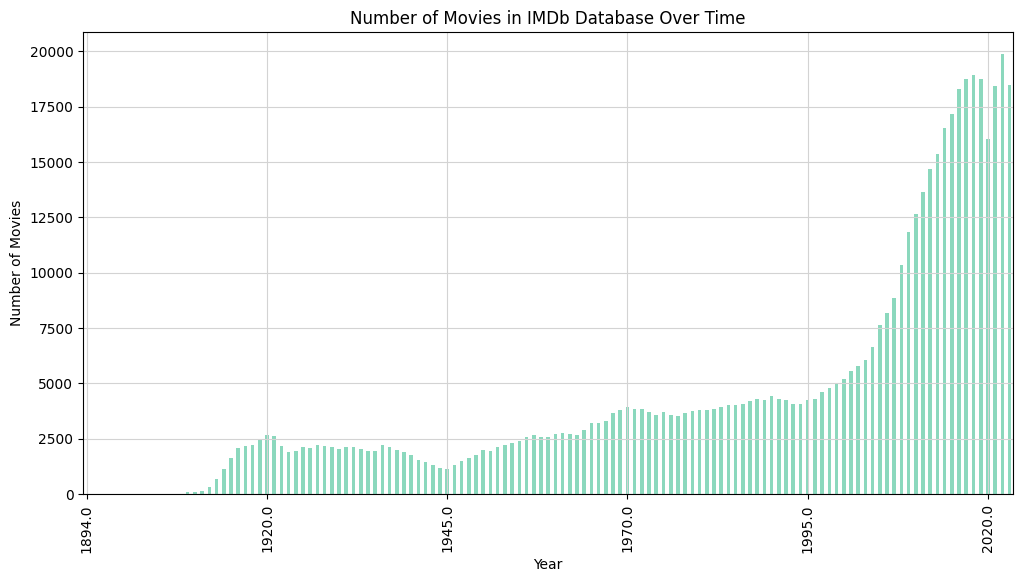

In [74]:
# Group by 'startYear' and count the number of movies
movies_per_year = movies.groupby('startYear').size()

# Plotting the number of movies over time as a bar chart
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='bar', color='#8BD8BD')
plt.title('Number of Movies in IMDb Database Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(range(0, len(movies_per_year), 25), labels=movies_per_year.index[::25]) # Adjust x-axis to show labels for every 25 years
plt.grid(True, color='#D3D3D3')  # Adding light grey grid lines for better readability
plt.show()


A lot more movies are made in the 21st century than previous centuries. This is probably due to advancements in technology, increased access to filmmaking tools, and the growth of digital distribution platforms, making it easier than ever to produce and share movies. Now, let's filter our dataset to include only movies released between 2000 and 2023 and see how many movies we have. 

In [30]:
# Filtering the 'movies' DataFrame to include only movies from the year 2000 to 2023
movies_2000_2023 = movies[(movies['startYear'] >= 2000) & (movies['startYear'] <= 2023)]

# Displaying the first few rows of the 'movies_2000_2023' DataFrame
movies_2000_2023.head()

,tconst,startYear,genres
11634,tt0011801,2019.0,"Action,Crime"
13079,tt0013274,2021.0,Documentary
15174,tt0015414,2000.0,\N
27745,tt0028248,2022.0,Musical
34798,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [31]:
# Counting the number of unique values in each column of the 'movies_2000_onward' DataFrame
movies_2000_2023.nunique()

tconst       313675
startYear        24
genres         1192
dtype: int64

We now have 313,675 movies made between 2000 and 2023, with information on each movie's ID (`tconst`), release year (`startYear`), and genres (`genres`). Before moving on to the next stage of analysis, we save this dataset to a CSV file so that we can use it later to construct a dynamic collaboration network among film-makers from 2000 to 2023. 

In [32]:
# Saving the DataFrame to a CSV file for future use
# 'index=False' omits the index column in the saved file
movies_2000_2023.to_csv('movies_2000_2023.csv', index=False)

# Identifying first-time directors and tracking full filmography 

In this section, we identify directors who made their directorial debut between 2003 and 2013. And then, we gather data on the movies they directed throughout their career.

Let's start by examining the `df_principals` DataFrame, which contains information on key personnel involved in each movie. Let's also take a quick look at the `category` to understand the different roles present in the dataset.

In [42]:
# Displaying the first few rows of the 'df_principals' DataFrame to examine its structure
df_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [43]:
# Counting and displaying the frequency of each role (category) in the 'df_principals' DataFrame
df_principals['category'].value_counts()

category
actor                  13322849
self                   10448069
actress                10392402
writer                  8435856
director                6951076
producer                3917208
cinematographer         2050878
editor                  1996902
composer                1996779
archive_footage          397891
production_designer      381792
archive_sound              4516
Name: count, dtype: int64

The data includes information on who (`nconst`) worked on which movie (`tconst`) in which capacity (`category`). Since the aim of the project is to examine the effects of networks for individuals in leadership positions, we filter the DataFrame to include only directors, who shape the artistic and creative vision of a movie.

Our next step is to identify directors whose first movie was released between 2003 and 2013. With this sample of first-time directors, we then create a DataFrame called `directors_full_filmography` that contains all movies directed by these first-time directors. 

In [37]:
# Filter 'df_principals' to include only entries where the category is 'director'
# This isolates directors from the principals data
directors = df_principals[df_principals['category'] == 'director']

# Merge the 'movies' DataFrame with the 'directors' DataFrame based on the 'tconst' field, 
# This links directors to the movies they directed
directors = movies.merge(directors[['tconst', 'nconst']], on='tconst', how='inner')

# Find the first movie for each director
# Group by director ('nconst') and aggregates the 'startYear' column to find the minimum year, i.e., the director's debut year
directors_first_movies = directors.groupby('nconst').agg({'startYear': 'min'}).reset_index()

# Rename the 'startYear' column to 'firstYear' to denote it as the year of the director's first movie
directors_first_movies = directors_first_movies.rename(columns={'startYear': 'firstYear'})

# Filter the results to include only directors whose first movie was released between 2003 and 2013
debut_directors_2003_2013 = directors_first_movies[(directors_first_movies['firstYear'] >= 2003) & (directors_first_movies['firstYear'] <= 2013)]

# Compiling the full filmography of these directors by filtering the 'directors' data 
# to include only movies directed by the identified first-time directors
directors_full_filmography = directors[directors['nconst'].isin(debut_directors_2003_2013['nconst'])]

# Merge with 'debut_directors_2003_2013' to include the first year of directing
directors_full_filmography = directors_full_filmography.merge(debut_directors_2003_2013, on='nconst', how='left')

Let's see how many directors we have in our data.

In [55]:
# Displaying the unique counts in the 'directors_full_filmography' DataFrame for an overview
directors_full_filmography.nunique()

tconst       115413
startYear        21
genres          948
nconst        63169
firstYear        11
dtype: int64

Our sample includes 63,169 directors. Let's count the number of movies each director made in their debut year.

In [22]:
# Count Movies Directed by the Directors in Their First Year

# Filter 'directors_full_filmography' to keep only movies directed in the director's first year
first_year_movies = directors_full_filmography[directors_full_filmography['startYear'] == directors_full_filmography['firstYear']]

# Group by director ('nconst') and counting the number of movies each directed in their first year
movies_count_first_year = first_year_movies.groupby('nconst').size()

# Counting and sorting the number of directors for each movie count in their first year
movies_count_first_year.value_counts().sort_index()

1    61775
2     1276
3       83
4       22
5        7
6        3
7        2
Name: count, dtype: int64

Looks the majority (98%) of directors in our sample directed only one movie in their first year, but a small group of directors did make more than one movie the year they started directing. 

To add depth to our analysis, we merge IMDb data on ratings and number of votes with our filmography dataset. This allows us to consider the popularity and reception of each movie directed by our cohort of first-time directors. 

In [56]:
# URL for the IMDb 'title.ratings' dataset
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

# Read the 'title.ratings' dataset 
df_ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip')

# Displaying the first few rows of 'df_ratings' for an overview
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2017
1,tt0000002,5.7,270
2,tt0000003,6.5,1943
3,tt0000004,5.4,178
4,tt0000005,6.2,2721


In [57]:
# Merge the ratings data with the 'directors_full_filmography' dataset
# This adds IMDb ratings and number of votes to the filmography data
directors_full_filmography = directors_full_filmography.merge(df_ratings, on='tconst', how='left')

# Save the 'directors_full_filmography' dataset to a CSV file for future use
directors_full_filmography.to_csv('directors_full_filmography.csv', index=False)

# Examining career pre- and post-directing debut

In this section, we delve into the work of these directors before and after their directorial debut.

## Career progression post-debut:

First, let's count the number of movies they directed after their debut. This helps us understand the career trajectory of first-time movie directors following their initial foray into directing. 

In [67]:
# Initialize a DataFrame to analyze the post-debut career of directors
# This DataFrame includes the unique identifier for each director ('nconst') and their first movie year
post_debut_director_movies = directors_full_filmography[['nconst', 'firstYear']].drop_duplicates()

# Initially assume all directors have directed zero movies after their debut
# This assumption will be updated based on the actual data 
post_debut_director_movies['movies_directed_after_first'] = 0

# Filter the full filmography to include only movies directed after the director's first movie
# This helps in focusing on the directors' career progression after their debut
movies_after_debut = directors_full_filmography[directors_full_filmography['startYear'] > directors_full_filmography['firstYear']]

# Group the data by director and count the number of movies directed after their debut
movies_count_after_debut = movies_after_debut.groupby('nconst').size()

# Update the DataFrame with the actual count of movies directed after the first movie
post_debut_director_movies.set_index('nconst', inplace=True)
post_debut_director_movies.loc[movies_count_after_debut.index, 'movies_directed_after_first'] = movies_count_after_debut
post_debut_director_movies.reset_index(inplace=True)

Let's generate of some descriptive statistics for the number of movies directed by these first-time directors after their debut.

In [72]:
# Get an overview of the distribution and central tendencies of the number of movies directed after debut
post_debut_director_movies['movies_directed_after_first'].describe()

count    63169.000000
mean         1.010021
std          2.359699
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        126.000000
Name: movies_directed_after_first, dtype: float64

On average, each of the 63,169 directors in our sample directed just over 1 movie after their debut. The median value is 0, indicating that more than half of the directors directed no movies after their debut. The 75th percentile (third quartile) is 1, meaning that 75% of the directors directed 1 or fewer movies after their debut. The median being lower than the mean, coupled with a high standard deviation, points to a skewed distribution. This suggests that while the majority directed few or no movies post-debut, a small subset of directors had notably more prolific careers.

To better understand this distribution, let's create a bar chart visualizing the count of movies directed by these directors after their debut.

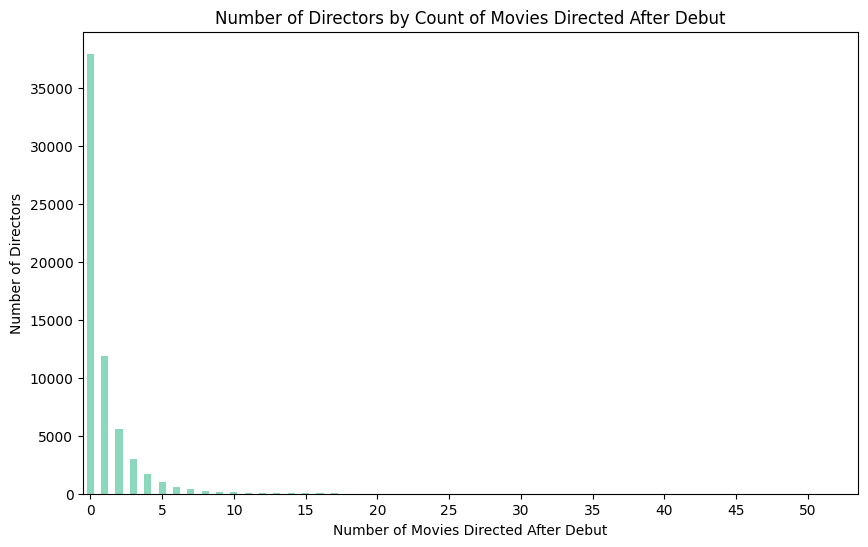

In [93]:
# Create a bar chart to visualize the number of movies directed by first-time directors after their debut
plt.figure(figsize=(10, 6))
director_counts_by_movie_number = post_debut_director_movies['movies_directed_after_first'].value_counts().sort_index()
director_counts_by_movie_number.plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Number of Directors by Count of Movies Directed After Debut')
plt.xlabel('Number of Movies Directed After Debut')
plt.ylabel('Number of Directors')

# Adjust the x-axis to show labels for every 5 movies for better readability
xticks = range(0, len(director_counts_by_movie_number), 5)
plt.xticks(ticks=xticks, labels=[str(i) for i in xticks], rotation=0)

plt.show()

Looks like the majority of directors did not direct another movie after their debut, aligning with the descriptive statistics above. 

## Background pre-debut

Some first-time directors might have worked on other movies in non-directing roles before they started directing. This prior experience might influence their career longevity as a director. Therefore, in this part of our analysis, we explore the extent and nature of their involvement in movie productions prior to their directing debut. We will create three variables to reflect a first-time director’s prior work experience, including whether they have worked on other movies in non-directing roles before they directed their first movie, and if so, how many movies and which role they took on in these movies.

In [75]:
# Filtering the principal dataset for entries related to our first-time directors
# This captures all the roles they have held in any film production, not just as directors
director_roles_pre_debut = df_principals[(df_principals['nconst'].isin(debut_directors_2003_2013['nconst']))]

# Merging this data with the movies dataset to associate each role with its corresponding release year
director_roles_pre_debut = director_roles_pre_debut[['tconst', 'nconst', 'category']].merge(movies[['tconst', 'startYear']], on='tconst', how='inner')

# Further merging with the debut directors dataset to include the year of each director's first movie
# This helps in identifying work done prior to their directorial debut
director_roles_pre_debut = director_roles_pre_debut.merge(debut_directors_2003_2013, on='nconst', how='left')

# Filtering for work before their directorial debut
# This step isolates their activities in the industry prior to becoming a director
pre_debut_work = director_roles_pre_debut[director_roles_pre_debut['startYear'] < director_roles_pre_debut['firstYear']]

# Excluding entries where their role was 'self' to focus on professional roles
pre_debut_work = pre_debut_work[pre_debut_work['category'] != "self"]

# Aggregating the data to count the number of movies and list the different roles each director held before their debut
pre_debut_experience = pre_debut_work.groupby('nconst').agg({
    'tconst': 'count', 
    'category': lambda x: list(set(x))
    }).rename(columns={'tconst': 'movie_count', 'category': 'roles'})

# Initializing a DataFrame to track each director's experience prior to their debut
directors_experience = pd.DataFrame({'nconst': directors_full_filmography['nconst']}).drop_duplicates()
directors_experience['had_prior_experience'] = 0  # Initializing with 0 (no experience)

# Merging with the pre_debut_experience data to get the movies count and different roles before debut
directors_experience = directors_experience.merge(pre_debut_experience, on='nconst', how='left')

# Filling missing values (NaNs) with 0 for directors without prior experience
directors_experience['movie_count'].fillna(0, inplace=True)

# Updating the 'had_prior_experience' flag to 1 for directors who had prior experience
directors_experience.loc[directors_experience['movie_count'] > 0, 'had_prior_experience'] = 1

Let's count the number of directors for each movie count.

In [123]:
directors_experience['movie_count'].value_counts().sort_index()

movie_count
0.0      52850
1.0       5774
2.0       1820
3.0        842
4.0        473
         ...  
106.0        1
112.0        1
124.0        1
160.0        1
163.0        1
Name: count, Length: 76, dtype: int64

Looks like the majority of first-time directors (84%) did not work in other movie productions before their directing debut.Let's creating a bar chart for those who did have prior experience to a sense of the variety and frequency of roles assumed by these directors.

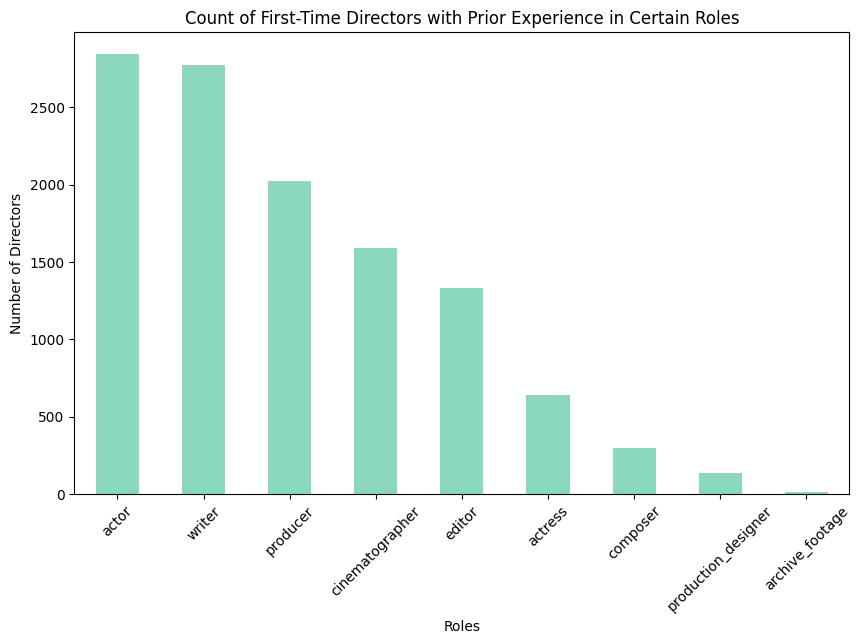

In [115]:
# Creating a bar chart to visualize the different roles taken by first-time directors before their debut

plt.figure(figsize=(10, 6))
# Flatten the list of roles and count each occurrence and create a bar chart
directors_experience.explode('roles')['roles'].value_counts().plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Count of First-Time Directors with Prior Experience in Certain Roles')
plt.xlabel('Roles')
plt.ylabel('Number of Directors')

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

Among first-time directors with prior industry experience, the most common roles are those of actors and writers. This  suggests a notable pathway into directing, where among people already in the film industry, those with substantial experience in acting or writing are more likely to transition into directing roles.

Finally, let's create a dataset to record the pre- and post-debut career of each director in our sample and save it for future analysis. 

In [127]:
# Merge the DataFrames on 'nconst'
directors_pre_post_debut_careers = directors_experience.merge(post_debut_director_movies, on='nconst', how='inner')

# Displaying the first few rows to get an overview of the data
directors_pre_post_debut_careers.head()

,nconst,had_prior_experience,movie_count,roles,firstYear,movies_directed_after_first
0,nm1131265,0,0.0,NaN,2004.0,2
1,nm1130611,0,0.0,NaN,2004.0,0
2,nm0290651,0,0.0,NaN,2003.0,0
3,nm0404033,0,0.0,NaN,2003.0,3
4,nm0000417,1,14.0,"[archive_footage, actor]",2005.0,1


In [126]:
# save the data for future analysis 
directors_pre_post_debut_careers.to_csv('directors_pre_post_debut_careers.csv', index=False)